## **kmeans**

se intenta hacer kmeans con los datos, falla épicamente

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import seaborn as sns
import sys
import scipy.signal as signal

import sys

import sys
sys.path.append('../Librerias')
import dataset as ds

sns.set_style("darkgrid")

In [40]:
# Load data

fpath = "/Users/granosftp/Documents/GitHub/Tesis/data/"
fname = "datosconsu_021023_bajos.mat"
cutoff = [9/1000, 11/1000]

set =  ds.MatFileToDataFrame(fpath, fname)
df = set.get_dataframe(cutoff)
df.tail()

,Original Signal,Signal - Mean,Filtered Signal,Hilbert Transform
599995,5.210999,-0.843661,0.006548,0.006548-0.079264j
599996,5.063692,-0.990968,0.005720,0.005720-0.080078j
599997,5.012726,-1.041933,0.004924,0.004924-0.097776j
599998,4.868050,-1.186610,0.004167,0.004167-0.099372j
599999,4.806563,-1.248097,0.003455,0.003455-0.151678j


In [41]:
#df = pd.DataFrame(mat['data'], columns = ['amp'])
df['amp_mean'] = df.amp - df.amp.mean()
df['dif'] = df.amp_mean.diff()
df.tail()

AttributeError: 'DataFrame' object has no attribute 'amp'

In [ ]:
# filtro pasa banda
order = 1
cutoff_freq = [9/1000, 11/1000]
b,a = signal.butter(order, cutoff_freq, btype='bandpass')

df_filtered = signal.filtfilt(b, a, df.amp_mean)

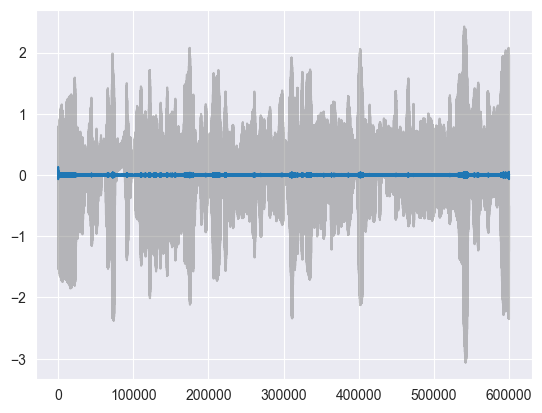

In [ ]:
plt.plot(df.amp_mean, color = 'grey', alpha = 0.5)
plt.plot(df_filtered)
plt.show()

In [51]:
df_window = np.array_split(df['Filtered Signal'], 50)
df_window =np.array(df_window)
df_window.shape

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


(50, 12000)

### **fase instantanea**
Se calcula la fase instantanea de toda la señal, dado que el cambio de fase es una serie de tiempo, por lo que no es necesario calcularlo para cada ventana.

In [52]:
# filtro de hilbert
#s_filt =  signal.hilbert(df_filtered)
amp_envelope_filt = np.abs(df['Hilbert Transform'])
inst_phase_filt =  np.unwrap(np.angle(df['Hilbert Transform']))
inst_freq_filt = (np.diff(inst_phase_filt)/(2.0*np.pi) * 1000)
diff_phase =  np.diff(inst_phase_filt)
diff_phase = np.insert(diff_phase, 0, 0) #agrego un cero en el primer coeficiente

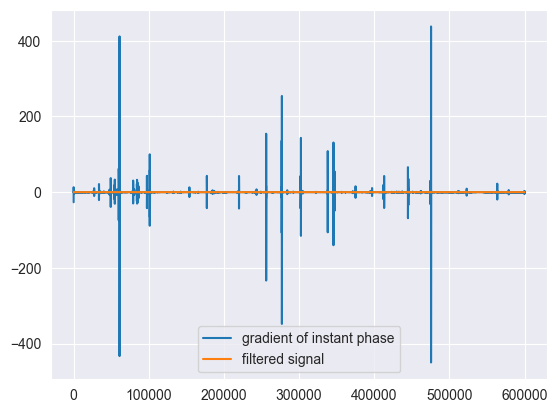

In [53]:
plt.plot(np.diff(inst_freq_filt), label = 'gradient of instant phase')
plt.plot(df['Filtered Signal'], label = 'filtered signal')
plt.legend()
plt.show()

Se separa el array en 100 arreglos de 6000 muestras cada uno para hacer un dataset con los elementops y hacer clusterings

In [64]:
window_phase = np.array_split(diff_phase, 50)
window_phase =np.array(window_phase)
window_phase.shape

(50, 12000)

In [65]:
# son 100 ventanas (columnas) con 6.000 datos (filas)
df_phase = pd.DataFrame(window_phase)#.transpose()
df_phase.head()

,0,1,2,3,4,5,6,7,8,9,...,11990,11991,11992,11993,11994,11995,11996,11997,11998,11999
0,0.000000,0.182185,0.014910,0.097034,0.018271,0.074986,0.020442,0.064658,0.022024,0.058587,...,0.065675,0.065568,0.065641,0.065565,0.065596,0.065529,0.065525,0.065469,0.065442,0.065414
1,0.065353,0.065320,0.065209,0.065161,0.064997,0.064969,0.064803,0.064814,0.064640,0.064649,...,0.064590,0.064624,0.064771,0.064825,0.064961,0.065071,0.065214,0.065338,0.065446,0.065556
2,0.065622,0.065770,0.065838,0.065994,0.066020,0.066164,0.066147,0.066290,0.066246,0.066379,...,0.070846,0.071505,0.071562,0.072196,0.072170,0.072734,0.072721,0.073191,0.073082,0.073524
3,0.073564,0.074018,0.074058,0.074504,0.074618,0.074952,0.075114,0.075429,0.075579,0.075713,...,0.053430,0.052663,0.052420,0.051709,0.051588,0.050804,0.050586,0.049833,0.049711,0.049028
4,0.048880,0.048098,0.047919,0.047211,0.047093,0.046456,0.046389,0.045754,0.045683,0.045219,...,0.031507,0.031280,0.030969,0.026784,0.020279,0.008844,-0.007243,-0.042349,-0.123269,-0.352014


### **clustering**

Primero intentamos con kmeans y se normalizan los datos. Se prueban 3 tipos: Standar, MinMax y Max. Se queda con Standar porque los tres tienen los mismos resultados.

#### **Static clustering con kmeans**

In [66]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler

norm =  StandardScaler()
kmeans =  KMeans(n_clusters=5, random_state=0)

In [67]:
#scaled = norm.fit_transform(df_phase)
#kmeans.fit(scaled)
kmeans.fit(df_phase)
labels = kmeans.predict(df_phase)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [68]:
labels = pd.DataFrame(labels, columns = ['labels'])
labels.value_counts()

labels
0         46
1          1
2          1
3          1
4          1
Name: count, dtype: int64

Agrego los labels al dataset, de manera de tener identificada las ventanas con su label respectivo. Luego elijo el cluster con menor cantidad de datos para analizar si en estas ventanas se encuentra el defecto o no.

In [69]:
df_phase['labels'] = labels
df_phase.head()

df_phase0 = df_phase[df_phase['labels'] == 0]
df_phase0.shape

(46, 12001)

##### **analisis de clusters**

Se toman los indices de estas ventanas y se buscan en el array con la señal original para ver espectograma u otras cosas.
Notar que se encontraron 4 clusters y solo 1 tenía más de 1 elemento y este es el que se esta inspeccionando.

In [70]:
df_interested = [df_phase0.index]

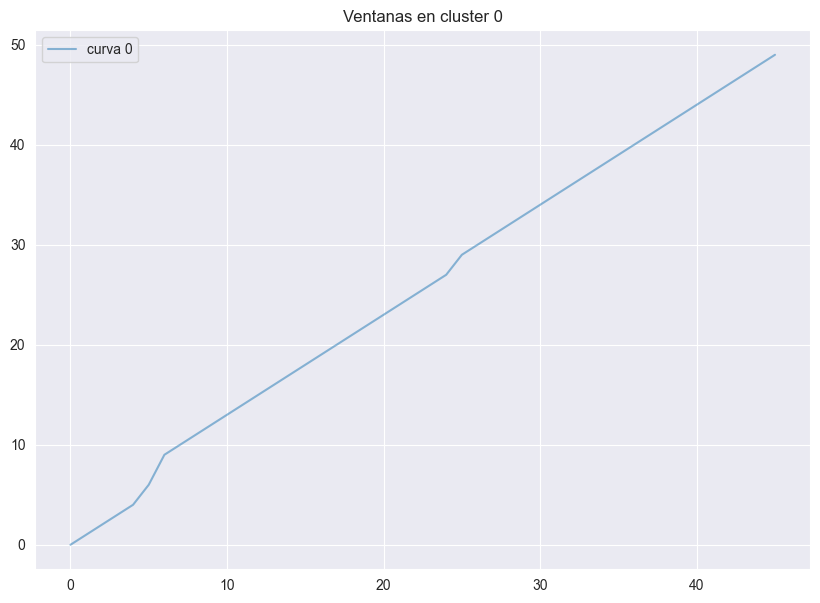

In [71]:
plt.figure(figsize = (10,7))
for i, elem in enumerate(df_interested):
    plt.plot(elem, label = f'curva {df_phase0.index[i]}', alpha = 0.5)
    
plt.title('Ventanas en cluster 0')
plt.legend()
plt.show()


A simple vista no se ve que estas ondas sean iguales o parecidas realmente.

**Espectogramas**

In [72]:
X = np.zeros([8,501,6])
f_ = []
t_ =[]

for i,window in enumerate(df_interested):
    f,t, Sxx = signal.spectrogram(window, fs = 1000, nperseg = 1000)
    X[i] = Sxx
    t_.append(t)
    f_.append(f)



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 1000 is greater than input length  = 46, using nperseg = 46
  warnings.warn('nperseg = {0:d} is greater than input length '


ValueError: could not broadcast input array from shape (24,1) into shape (501,6)

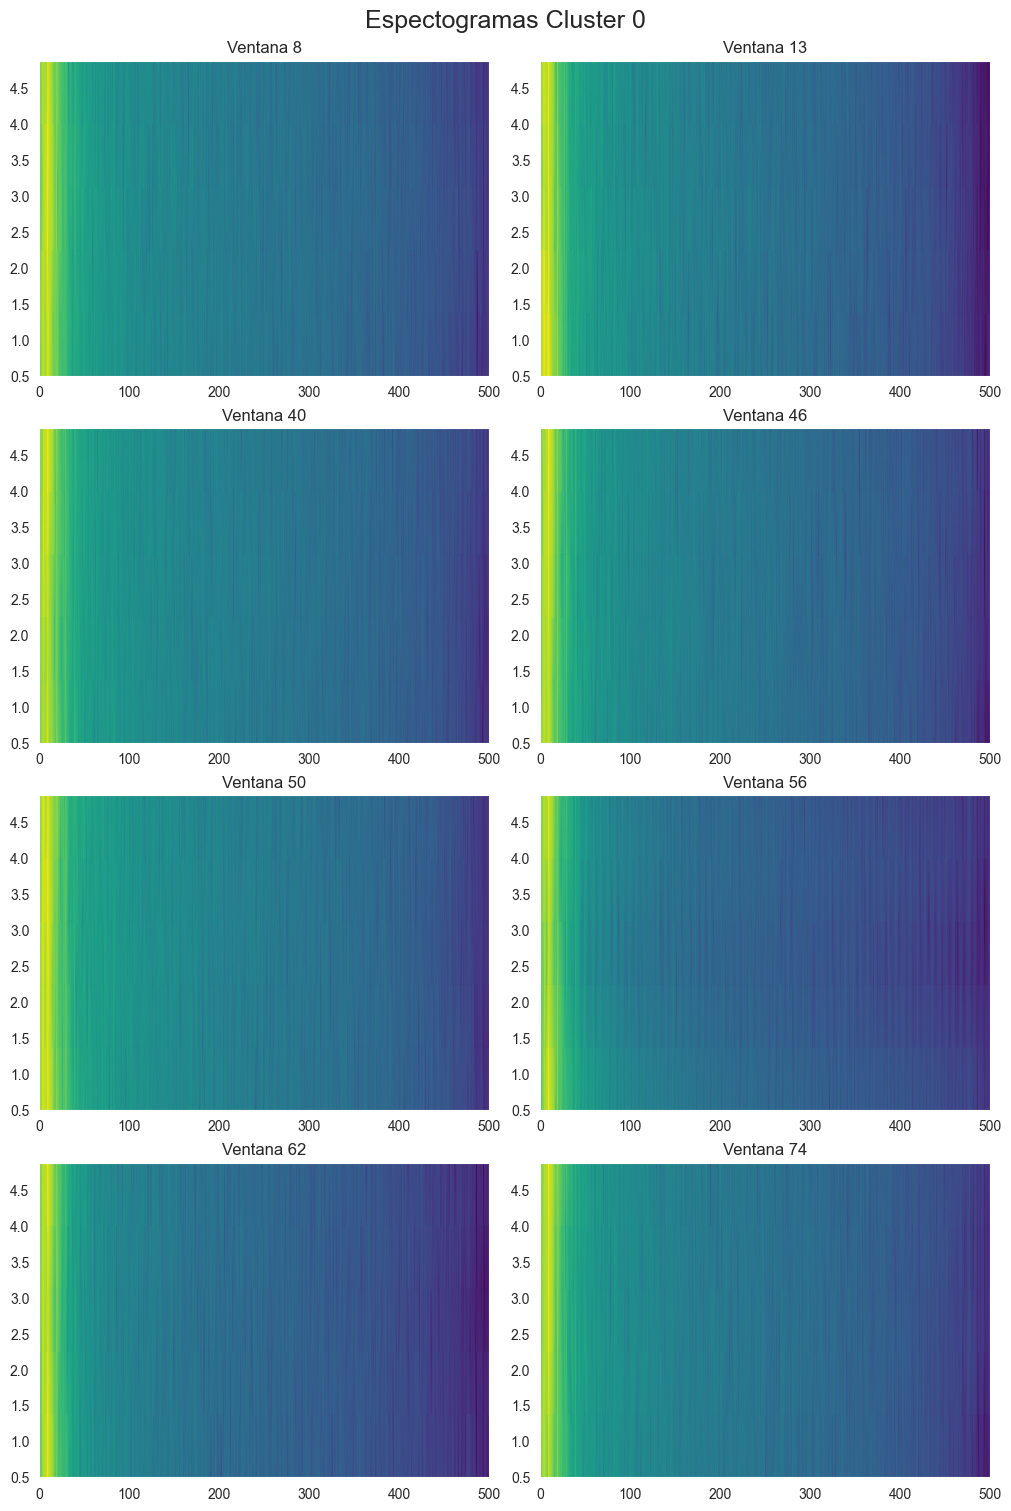

In [ ]:
#plt.figure(figsize = (10,10))

figure, axis = plt.subplots(4, 2, figsize = (10,15), constrained_layout=True)
figure.suptitle('Espectogramas Cluster 0', fontsize = 18)
x = [0,1,0,1,0,1,0,1]
y = [0,0,1,1,2,2,3,3]
for i,elem in enumerate(X):
    axis[y[i],x[i]].pcolormesh(f_[i],t_[i],elem.T, shading='gouraud', cmap = 'viridis', norm = 'log')
    #plt.xlim([0,150])
    #plt.ylabel('Segmento Temporal [n]')
    #plt.xlabel('Frecuencia [Hz]')
    axis[y[i]][x[i]].set_title(f'Ventana {df_phase0.index[i]}')
plt.show()

Especificamente, no se ven mayores diferencias en los espectogramas de las distintas ventanas en el cluster, por lo que se va a tomar una ventana anterior y una después para ver si hay alguna diferencia.
Especificamente, de la ventana 50

In [ ]:
indices = [61, 62, 63]
df_50 = df_window[indices]

X50 = np.zeros([3,501,6])
f_ = []
t_ =[]

for i,window in enumerate(df_50):
    f,t, Sxx = signal.spectrogram(window, fs = 1000, nperseg = 1000)
    X50[i] = Sxx
    t_.append(t)
    f_.append(f)


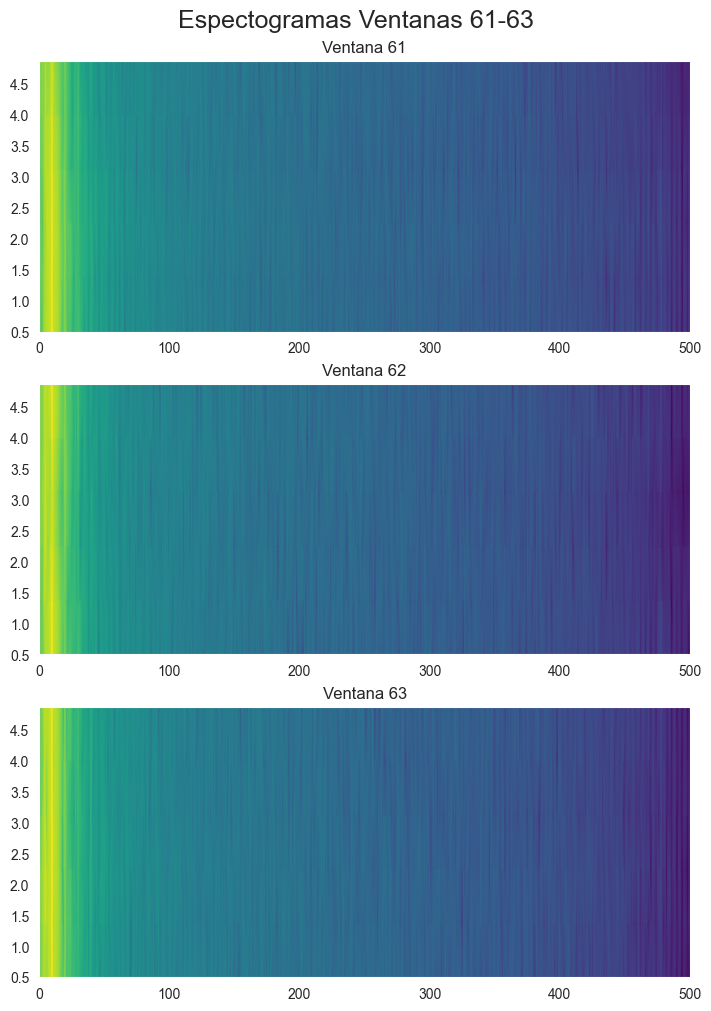

In [ ]:
figure, axis = plt.subplots(3, 1, figsize = (7,10), constrained_layout=True)
figure.suptitle(f'Espectogramas Ventanas {indices[0]}-{indices[-1]}', fontsize = 18)
for i,elem in enumerate(X50):
    axis[i].pcolormesh(f_[i],t_[i],elem.T, shading='gouraud', cmap = 'viridis', norm = 'log')
    #plt.xlim([0,150])
    #plt.ylabel('Segmento Temporal [n]')
    #plt.xlabel('Frecuencia [Hz]')
    axis[i].set_title(f'Ventana {indices[i]}')
plt.show()

Se hace una resta de los espectogramas, para ver si existe alguna diferencia sustancial entre las frecuencias encontradas

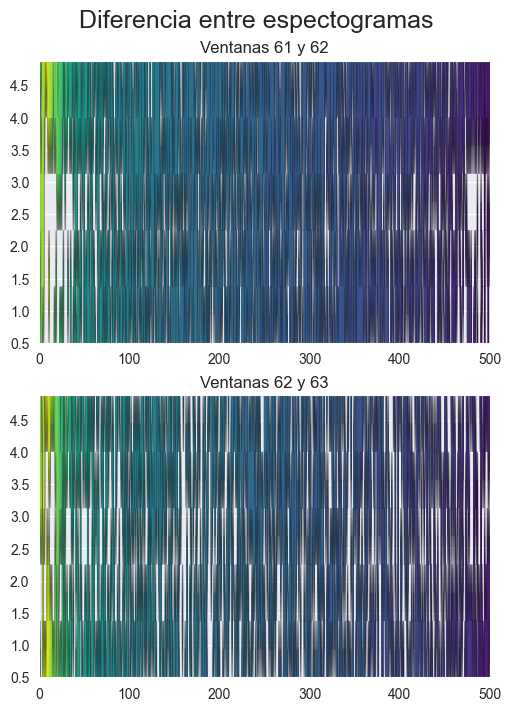

In [ ]:
X60_dif =  [X50[1]-X50[0], X50[1]-X50[2]]

figure, axis = plt.subplots(2, 1, figsize = (5,7), constrained_layout=True)
figure.suptitle(f'Diferencia entre espectogramas', fontsize = 18)
for i,elem in enumerate(X60_dif):
    axis[i].pcolormesh(f_[i],t_[i],elem.T, shading='gouraud', cmap = 'viridis', norm = 'log')
    axis[i].set_title(f'Ventanas {indices[i]} y {indices[i+1]}')
plt.show()

No se ve nada muy diferente, por lo que se va a probar con otro tipo de clustering u otra forma de buscar diferencias.
Nota: para los tres scalers ocupados, con la misma semilla, no hay cambio en los clusters, por lo que se supone que el cluster es estable pero este no muestra ser de interes.